# Lab 5 Wide and Deep Networks
## Zekai Wang
## 11/13/2019
## Master of Applied Statistics and Data Analytics

## 1 Business Understanding and Data Preparation

### 1.1 Business Understanding
As machine learning and deep learning algorithms have been more widely used in the biomedical field, people are getting more and more accurate in the diagnosis of certain diseases such as breast cancer and malaria. In diagnosis of Cardiovascular, for example, if a doctor is able to use some deep learning algorithms to identify whether nor not they have cardiovascular disease, not only can the doctor's workload be greatly reduced, but also the accuracy of the diagnosis can be greatly improved. Patients and doctors will benefit from this precise model.From this perspective, I selected Cardiovascular Disease dataset from kaggle for this exploring table data. To be more specific, the goal for this dataset is to figure out whether or not a patient has cardiovascular disease


In addition, If I want my model to have practical value, then not only should the total accuarcy be relatively high but also false negative rate should be relatively low and true positive rate also should be relatively high. Especially for medical diagnosis, it is more important to have a lower false negative rate, that is, 
the cost of not diagnosing that a person has a cardiovascular disease is much higher than we misdiagnosed a healthy person with cardiovascular disease. Therefore, I want to have a higher recall score for this dataset.

Data: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

### 1.2 Data Preparation
Before I did analysis, I first checked th dataset. For this dataset, there is 11 features and 1 outcome variable (cardio). In those 11 features, there are 6 categorical features and 5 numerical features. For all categorical variables, they are all integer classes. For the convenience of analysis, I changed gender class (1,2) into (1,0). For numerical data, I first changed representing age in days into representing age in years. In addtion, because there is great difference in their scale, which can have a bad impact on prediction. I standardized these numerical data before I built models.

For cross-product features, I chose three different combination. The first is 'alco' and 'smoke',  and 'cholesterol' and 'gluc'. This is because I think a patient who smoking and drinking will be a very strong indictor for cardiovascular disease and a high level Glucose and Cholesterol will also be a strong negative indictor. The second combination is I put all the features together in pairs, because I just had 6 categorical features and the classes is not large for each one. The third part is ('gender','smoke','alco') and ('gluc', 'active', 'cholesterol'), because those two combination also can give a strong indictor for cardiovascular disease.

For evaluatation of algorithm’s performance, I chose recall score. This is because my outcome variable is a binary class and also balanced. In addition, people paid more attention to false negative rate in medical diagnosis. From this perspective, I selected recall score.

For dividing data into training and testing, because my dataset contains 70,000 instances, which is large enough. I use 80/20 split, that is, I split my dataset into training set containing 56,000 instances and testing set containing 14,000. In addtion, my training set is still large enough (56,000), so in choosing the best layers and cross-product features, I still used 80/20 split to create a validation set to select the best performance model. 

In [370]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model
from keras import metrics

from sklearn import metrics as mt
from keras.layers import concatenate
from sklearn.manifold import TSNE

In [2]:
df_raw = pd.read_csv('cardio.csv', sep = ';')

In [3]:
len(df_raw[df_raw['cardio']==1])

34979

In [4]:
len(df_raw[df_raw['cardio']==0])

35021

In [5]:
df_raw.head(6)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0


In [168]:
#change age into age_year
#drop 'id' variable
#change gender from(1,2) into (1,0)
df_raw['age_year'] = round(df_raw['age']/365).astype(int)
df_cardio = df_raw.drop(columns=['age','id'])
#df_cardio['gender'][df_cardio['gender']==2] = 0
for i in range(len(df_cardio)):
    if df_cardio.loc[i,'gender']==2:
        df_cardio.loc[i,'gender'] = 0

#change the order of variables
cols = list(df_cardio)
cols.insert(1,cols.pop(cols.index('age_year')))
df_cardio = df_cardio[cols]
df_cardio.head()

,gender,age_year,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,168,62.0,110,80,1,1,0,0,1,0
1,1,55,156,85.0,140,90,3,1,0,0,1,1
2,1,52,165,64.0,130,70,3,1,0,0,0,1
3,0,48,169,82.0,150,100,1,1,0,0,1,1
4,1,48,156,56.0,100,60,1,1,0,0,0,0


In [169]:
#scaling numerical variable
categorical_headers = ['gender','cholesterol','gluc','smoke','alco','active'] #as integer
numerical_headers = ['age_year', 'height', 'weight','ap_hi','ap_lo']
feature_headers = categorical_headers + numerical_headers
std1 = StandardScaler()
df_cardio_std = df_cardio[numerical_headers]

std_scale = std1.fit(df_cardio_std)
df_cardio_std1 = std_scale.transform(df_cardio_std)

df_cardio_std1_col = pd.DataFrame(df_cardio_std1, index=list(range(0,70000)),columns=df_cardio_std.columns) 
df_cardio.update(df_cardio_std1_col)
df_cardio.head()

/Users/zekaiwang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/zekaiwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


,gender,age_year,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,-0.493505,0.443452,-0.847873,-0.122182,-0.088238,1,1,0,0,1,0
1,1,0.245566,-1.018168,0.749831,0.072610,-0.035180,3,1,0,0,1,1
2,1,-0.197877,0.078047,-0.708942,0.007679,-0.141297,3,1,0,0,0,1
3,0,-0.789134,0.565254,0.541435,0.137541,0.017879,1,1,0,0,1,1
4,1,-0.789134,-1.018168,-1.264666,-0.187113,-0.194356,1,1,0,0,0,0


In [174]:
#80/20 split, because this dataset is balanced and large enough
X_train, X_test, y_train, y_test = train_test_split(df_cardio[feature_headers],
                                                    df_cardio['cardio'], test_size=0.2,
                                                   random_state = 1)

# Crossed Columns and Deep Embeddings
  

In this part，I selected 3 different combination and two different number of hidden layers, 2 and 5. According to the recall score, the first combination:'alco' and 'smoke',  and 'cholesterol' and 'gluc' with 2 hidden layers has the best performance.
## Model 1 
### The first combination with 2 hidden layers

In [496]:
#'workclass','education','marital_status','occupation','relationship','race','sex','country'

cross_columns = [['alco','smoke'],
                 ['gender', 'active'],
                 ['cholesterol','gluc']]


# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = X_train[cols].astype('str').apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols].astype('str').apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = len(np.unique(X_ints_train[-1])) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

# reset this input branch
all_deep_branch_outputs = []
# add in the embeddings
for col in categorical_headers:
    # encode as ints for the embedding
    X_ints_train.append( X_train[col].values )
    X_ints_test.append( X_test[col].values )
    
    # get the number of categories
    N = len(np.unique(X_ints_train[-1])) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train[numerical_headers].shape[1],),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append( x )

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=30,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep2')(deep_branch)
    
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)


# merge the deep branches together
deep_branch1_2 = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch1_2 = Dense(units=50,activation='relu', name='deep1')(deep_branch1_2)
deep_branch1_2 = Dense(units=40,activation='relu', name='deep2')(deep_branch1_2)
deep_branch1_2 = Dense(units=30,activation='relu', name='deep3')(deep_branch1_2)
deep_branch1_2 = Dense(units=20,activation='relu', name='deep4')(deep_branch1_2)
deep_branch1_2 = Dense(units=10,activation='relu', name='deep5')(deep_branch1_2)
    
final_branch1_2 = concatenate([wide_branch, deep_branch1_2],name='concat_deep_wide')
final_branch1_2 = Dense(units=1,activation='sigmoid',name='combined')(final_branch1_2)

model1_2 = Model(inputs=all_inputs, outputs=final_branch1_2)



In [493]:
model.summary()

Model: "model_60"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gender (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
cholesterol (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
gluc (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
smoke (InputLayer)              (None, 1)            0                                            
___________________________________________________________________________________________

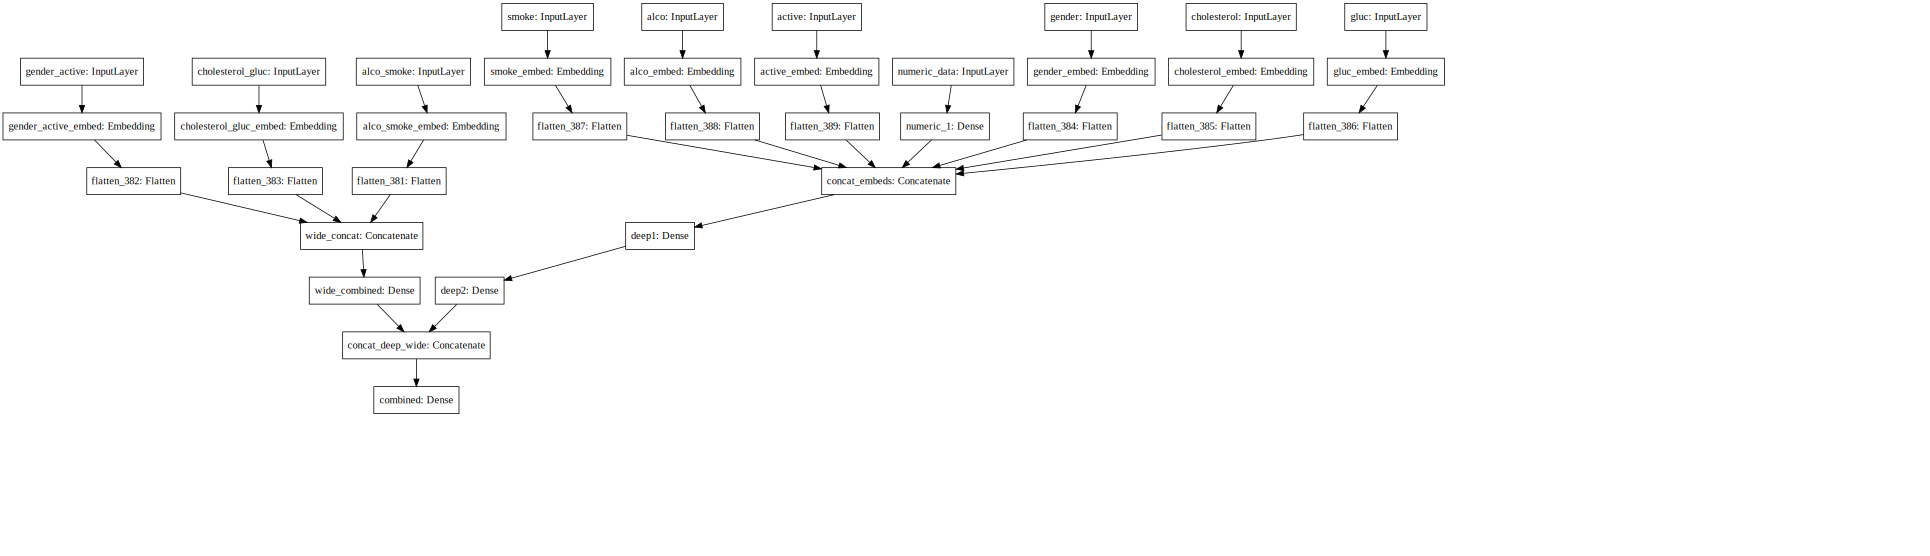

In [482]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [505]:
%%time
#custom recall

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=[metrics.Recall()])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit(X_ints_train + [X_train[numerical_headers].values],
                    y_train, 
                    epochs=20, 
                    batch_size=32, 
                    verbose=0, 
                    validation_split = 0.2)


Text(0.5, 1.0, 'MSE Loss')

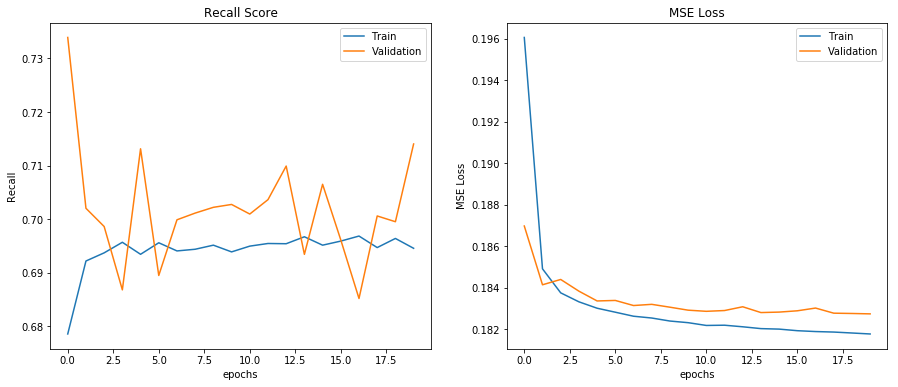

In [547]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
p1, = plt.plot(history.history['recall_21'])
p2, = plt.plot(history.history['val_recall_21'])
plt.legend([p1, p2], ['Train', 'Validation'])
plt.ylabel('Recall')
plt.xlabel('epochs')
plt.title('Recall Score')

#plt.ylabel('Recall %')
#plt.title('Training')
#plt.subplot(2,2,2)
#plt.plot(history.history['val_recall_21'])
#plt.title('Validation')

plt.subplot(1,2,2)
p3, = plt.plot(history.history['loss'])
p4, = plt.plot(history.history['val_loss'])
plt.legend([p3, p4], ['Train', 'Validation'])
plt.ylabel('MSE Loss')
plt.xlabel('epochs')
plt.title('MSE Loss')

#plt.subplot(2,2,4)
#plt.plot(history.history['val_loss'])


### The first combination with 5 hidden layers

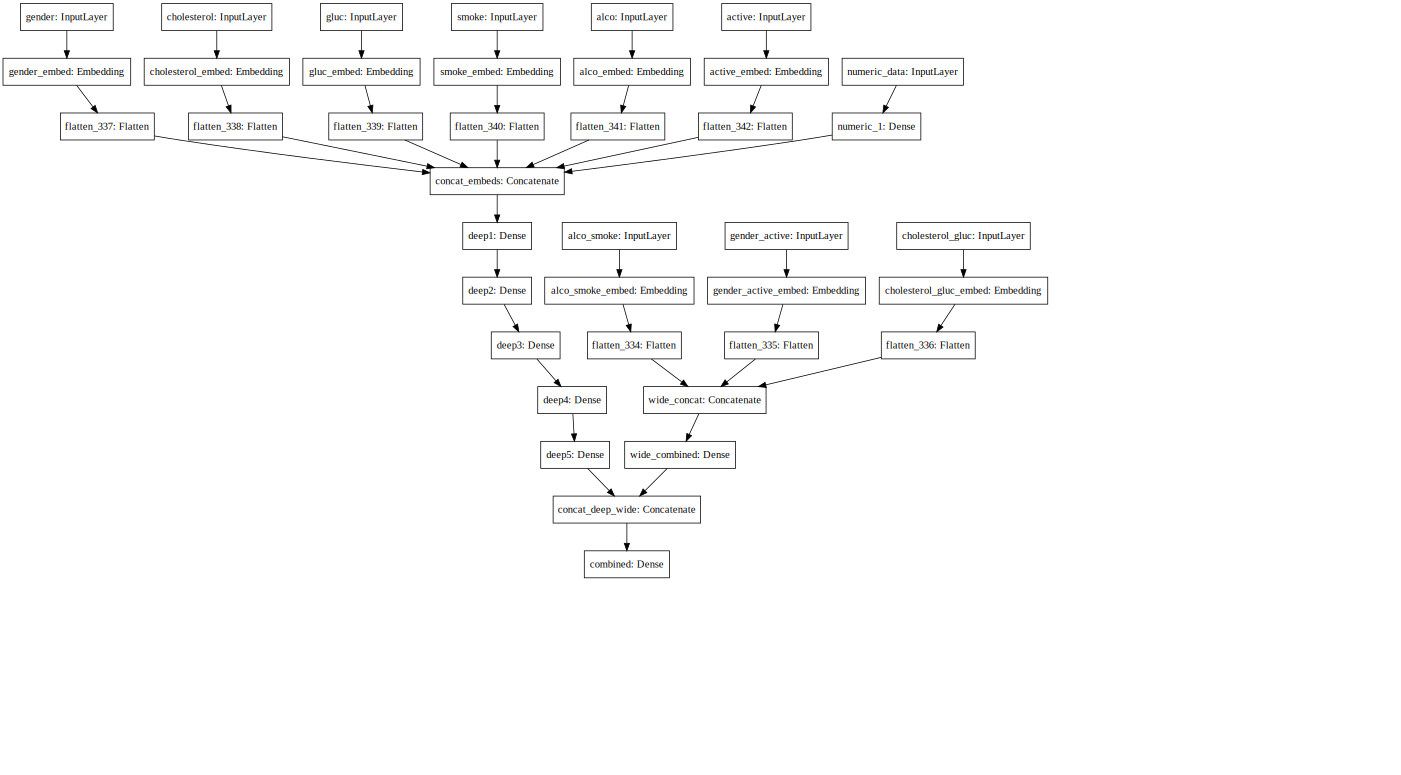

In [293]:
SVG(model_to_dot(model1_2).create(prog='dot', format='svg'))

In [294]:
%%time
#custom recall

model1_2.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=[metrics.Recall()])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history1_2 = model1_2.fit(X_ints_train+ [X_train[numerical_headers].values],
                    y_train, 
                    epochs=20, 
                    batch_size=32, 
                    verbose=1, 
                    validation_split = 0.2)

/Users/zekaiwang/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 44800 samples, validate on 11200 samples
Epoch 1/20
44800/44800 [==============================] - 3s 71us/step - loss: 0.1868 - recall_22: 0.6913 - val_loss: 0.1833 - val_recall_22: 0.7094
Epoch 2/20
44800/44800 [==============================] - 3s 61us/step - loss: 0.1832 - recall_22: 0.6919 - val_loss: 0.1830 - val_recall_22: 0.6764
Epoch 3/20
44800/44800 [==============================] - 3s 61us/step - loss: 0.1824 - recall_22: 0.6936 - val_loss: 0.1842 - val_recall_22: 0.6395
Epoch 4/20
44800/44800 [==============================] - 3s 61us/step - loss: 0.1821 - recall_22: 0.6916 - val_loss: 0.1827 - val_recall_22: 0.6782
Epoch 5/20
44800/44800 [==============================] - 3s 61us/step - loss: 0.1818 - recall_22: 0.6939 - val_loss: 0.1826 - val_recall_22: 0.6660
Epoch 6/20
44800/44800 [==============================] - 3s 63us/step - loss: 0.1816 - recall_22: 0.6922 - val_loss: 0.1821 - val_recall_22: 0.6997
Epoch 7/20
44800/44800 [==============================] 

Text(0.5, 1.0, 'MSE Loss')

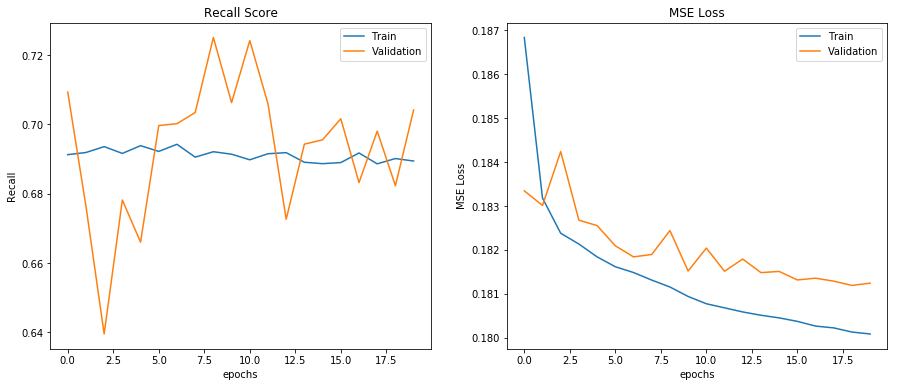

In [550]:
%matplotlib inline

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
p1, = plt.plot(history1_2.history['recall_22'])
p2, = plt.plot(history1_2.history['val_recall_22'])
plt.legend([p1, p2], ['Train', 'Validation'])
plt.ylabel('Recall')
plt.xlabel('epochs')
plt.title('Recall Score')

#plt.ylabel('Recall %')
#plt.title('Training')
#plt.subplot(2,2,2)
#plt.plot(history.history['val_recall_21'])
#plt.title('Validation')

plt.subplot(1,2,2)
p3, = plt.plot(history1_2.history['loss'])
p4, = plt.plot(history1_2.history['val_loss'])
plt.legend([p3, p4], ['Train', 'Validation'])
plt.ylabel('MSE Loss')
plt.xlabel('epochs')
plt.title('MSE Loss')

## Model 2

### The second combination with 2 hidden layers

In [298]:
#'gender','cholesterol','gluc','smoke','alco','active'

cross_columns2 = [['gender','cholesterol'],
                  ['gender','gluc'],
                  ['gender','smoke'],
                  ['gender','alco'],
                  ['gender','active'],
                  ['cholesterol','smoke'],
                  ['cholesterol','gluc'],
                  ['cholesterol','alco'],
                  ['cholesterol','active'],
                  ['gluc','smoke'],
                  ['gluc','alco'],
                  ['gluc','active'],
                  ['smoke','alco'],
                  ['smoke','active'],
                  ['alco','active']
                 ]


# we need to create separate lists for each branch
embed_branches2 = []
X_ints_train2 = []
X_ints_test2 = []
all_inputs2 = []
all_wide_branch_outputs2 = []

for cols in cross_columns2:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train2 = X_train[cols].astype('str').apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test2 = X_test[cols].astype('str').apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train2.values,  X_crossed_test2.values)))
    X_crossed_train2 = enc.transform(X_crossed_train2)
    X_crossed_test2 = enc.transform(X_crossed_test2)
    X_ints_train2.append( X_crossed_train2 )
    X_ints_test2.append( X_crossed_test2 )
    
    # get the number of categories
    N = len(np.unique(X_ints_train2[-1])) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs2 = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs2.append(inputs2)
    x2 = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs2)
    x2 = Flatten()(x2)
    all_wide_branch_outputs2.append(x2)
    
# merge the branches together
wide_branch2 = concatenate(all_wide_branch_outputs2, name='wide_concat')
wide_branch2 = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch2)

# reset this input branch
all_deep_branch_outputs2 = []
# add in the embeddings
for col in categorical_headers:
    # encode as ints for the embedding
    X_ints_train2.append( X_train[col].values )
    X_ints_test2.append( X_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train2[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs2 = Input(shape=(1,),dtype='int32', name=col)
    all_inputs2.append(inputs2)
    x2 = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs2)
    x2 = Flatten()(x2)
    all_deep_branch_outputs2.append(x2)
    
# also get a dense branch of the numeric features
all_inputs2.append(Input(shape=(X_train[numerical_headers].shape[1],),
                        sparse=False,
                        name='numeric_data'))

x2 = Dense(units=20, activation='relu',name='numeric_1')(all_inputs2[-1])
all_deep_branch_outputs2.append( x2 )

# merge the deep branches together
deep_branch2 = concatenate(all_deep_branch_outputs2,name='concat_embeds')
deep_branch2 = Dense(units=30,activation='relu', name='deep1')(deep_branch2)
deep_branch2 = Dense(units=10,activation='relu', name='deep2')(deep_branch2)
    
final_branch2 = concatenate([wide_branch2, deep_branch2],name='concat_deep_wide')
final_branch2 = Dense(units=1,activation='sigmoid',name='combined')(final_branch2)

model2 = Model(inputs=all_inputs2, outputs=final_branch2)

# merge the deep branches together
deep_branch2_2 = concatenate(all_deep_branch_outputs2,name='concat_embeds')
deep_branch2_2 = Dense(units=50,activation='relu', name='deep1')(deep_branch2_2)
deep_branch2_2 = Dense(units=40,activation='relu', name='deep2')(deep_branch2_2)
deep_branch2_2 = Dense(units=30,activation='relu', name='deep3')(deep_branch2_2)
deep_branch2_2 = Dense(units=20,activation='relu', name='deep4')(deep_branch2_2)
deep_branch2_2 = Dense(units=10,activation='relu', name='deep5')(deep_branch2_2)
    
final_branch2_2 = concatenate([wide_branch2, deep_branch2_2],name='concat_deep_wide')
final_branch2_2 = Dense(units=1,activation='sigmoid',name='combined')(final_branch2_2)

model2_2 = Model(inputs=all_inputs2, outputs=final_branch2_2)



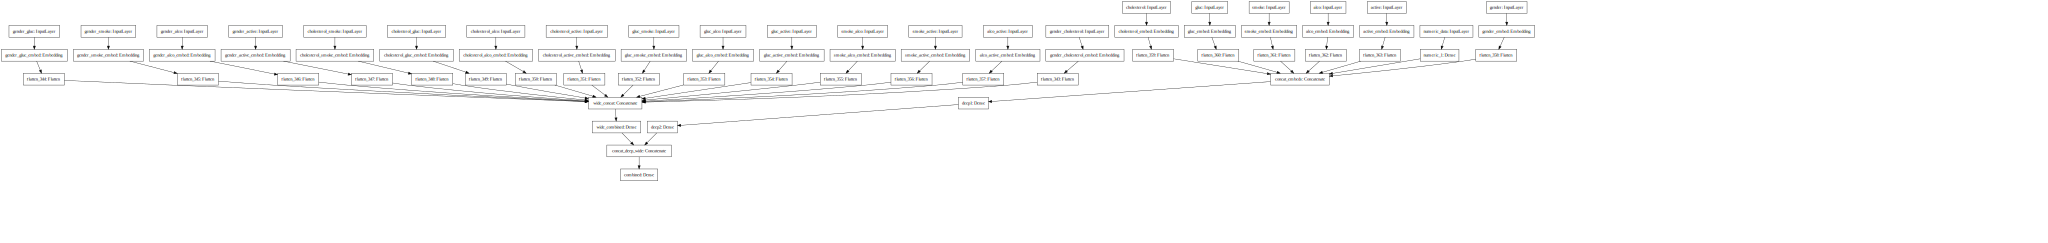

In [299]:
# you will need to install pydot properly on your machine to get this running
SVG(model_to_dot(model2).create(prog='dot', format='svg'))

In [300]:
%%time

model2.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=[metrics.Recall()])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history2 = model2.fit(X_ints_train2+ [X_train[numerical_headers].values],
                    y_train, 
                    epochs=20, 
                    batch_size=32, 
                    verbose=1, 
                    validation_split = 0.2)

/Users/zekaiwang/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 44800 samples, validate on 11200 samples
Epoch 1/20
44800/44800 [==============================] - 4s 92us/step - loss: 0.2045 - recall_23: 0.6618 - val_loss: 0.1900 - val_recall_23: 0.6922
Epoch 2/20
44800/44800 [==============================] - 3s 78us/step - loss: 0.1875 - recall_23: 0.6911 - val_loss: 0.1861 - val_recall_23: 0.6898
Epoch 3/20
44800/44800 [==============================] - 4s 78us/step - loss: 0.1852 - recall_23: 0.6941 - val_loss: 0.1854 - val_recall_23: 0.6859
Epoch 4/20
44800/44800 [==============================] - 3s 78us/step - loss: 0.1844 - recall_23: 0.6954 - val_loss: 0.1846 - val_recall_23: 0.7112
Epoch 5/20
44800/44800 [==============================] - 4s 78us/step - loss: 0.1838 - recall_23: 0.6947 - val_loss: 0.1841 - val_recall_23: 0.7060
Epoch 6/20
44800/44800 [==============================] - 3s 78us/step - loss: 0.1835 - recall_23: 0.6953 - val_loss: 0.1839 - val_recall_23: 0.7015
Epoch 7/20
44800/44800 [==============================] 

Text(0.5, 1.0, 'MSE Loss')

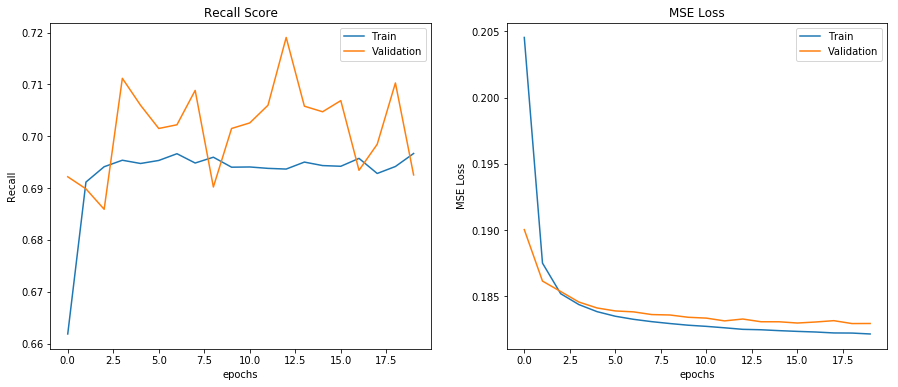

In [551]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
p1, = plt.plot(history2.history['recall_23'])
p2, = plt.plot(history2.history['val_recall_23'])
plt.legend([p1, p2], ['Train', 'Validation'])
plt.ylabel('Recall')
plt.xlabel('epochs')
plt.title('Recall Score')

#plt.ylabel('Recall %')
#plt.title('Training')
#plt.subplot(2,2,2)
#plt.plot(history.history['val_recall_21'])
#plt.title('Validation')

plt.subplot(1,2,2)
p3, = plt.plot(history2.history['loss'])
p4, = plt.plot(history2.history['val_loss'])
plt.legend([p3, p4], ['Train', 'Validation'])
plt.ylabel('MSE Loss')
plt.xlabel('epochs')
plt.title('MSE Loss')

## Model 2-2

### The second combination with 5 hidden layers

In [303]:
%%time

model2_2.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=[metrics.Recall()])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history2_2 = model2_2.fit(X_ints_train2+ [X_train[numerical_headers].values],
                    y_train, 
                    epochs=20, 
                    batch_size=32, 
                    verbose=1, 
                    validation_split = 0.2)

/Users/zekaiwang/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 44800 samples, validate on 11200 samples
Epoch 1/20
44800/44800 [==============================] - 5s 104us/step - loss: 0.1827 - recall_25: 0.6930 - val_loss: 0.1819 - val_recall_25: 0.7027
Epoch 2/20
44800/44800 [==============================] - 4s 85us/step - loss: 0.1811 - recall_25: 0.6914 - val_loss: 0.1817 - val_recall_25: 0.7312
Epoch 3/20
44800/44800 [==============================] - 4s 85us/step - loss: 0.1805 - recall_25: 0.6973 - val_loss: 0.1813 - val_recall_25: 0.6787
Epoch 4/20
44800/44800 [==============================] - 4s 85us/step - loss: 0.1803 - recall_25: 0.6970 - val_loss: 0.1812 - val_recall_25: 0.6970
Epoch 5/20
44800/44800 [==============================] - 4s 85us/step - loss: 0.1800 - recall_25: 0.6950 - val_loss: 0.1811 - val_recall_25: 0.7078
Epoch 6/20
44800/44800 [==============================] - 4s 85us/step - loss: 0.1799 - recall_25: 0.6984 - val_loss: 0.1813 - val_recall_25: 0.7033
Epoch 7/20
44800/44800 [==============================]

Text(0.5, 1.0, 'MSE Loss')

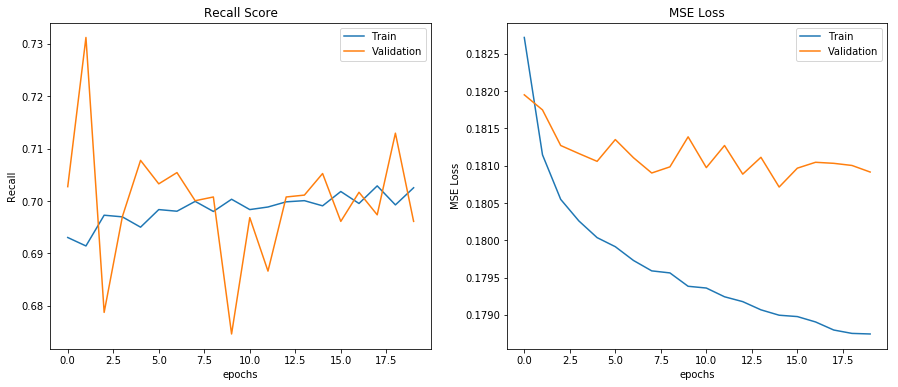

In [552]:
%matplotlib inline

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
p1, = plt.plot(history2_2.history['recall_25'])
p2, = plt.plot(history2_2.history['val_recall_25'])
plt.legend([p1, p2], ['Train', 'Validation'])
plt.ylabel('Recall')
plt.xlabel('epochs')
plt.title('Recall Score')

#plt.ylabel('Recall %')
#plt.title('Training')
#plt.subplot(2,2,2)
#plt.plot(history.history['val_recall_21'])
#plt.title('Validation')

plt.subplot(1,2,2)
p3, = plt.plot(history2_2.history['loss'])
p4, = plt.plot(history2_2.history['val_loss'])
plt.legend([p3, p4], ['Train', 'Validation'])
plt.ylabel('MSE Loss')
plt.xlabel('epochs')
plt.title('MSE Loss')

## Model 3

### The third combination with 2 hidden layers

In [305]:
#'gender','cholesterol','gluc','smoke','alco','active'

cross_columns3 = [['gender','smoke','alco'],
                 ['gluc', 'active', 'cholesterol']]


# we need to create separate lists for each branch
embed_branches3 = []
X_ints_train3 = []
X_ints_test3 = []
all_inputs3 = []
all_wide_branch_outputs3 = []

for cols in cross_columns3:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train3 = X_train[cols].astype('str').apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test3 = X_test[cols].astype('str').apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train3.values,  X_crossed_test3.values)))
    X_crossed_train3 = enc.transform(X_crossed_train3)
    X_crossed_test3 = enc.transform(X_crossed_test3)
    X_ints_train3.append( X_crossed_train3 )
    X_ints_test3.append( X_crossed_test3 )
    
    # get the number of categories
    N = len(np.unique(X_ints_train3[-1])) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs3 = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs3.append(inputs3)
    x3 = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs3)
    x3 = Flatten()(x3)
    all_wide_branch_outputs3.append(x3)
    
# merge the branches together
wide_branch3 = concatenate(all_wide_branch_outputs3, name='wide_concat')
wide_branch3 = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch3)

# reset this input branch
all_deep_branch_outputs3 = []
# add in the embeddings
for col in categorical_headers:
    # encode as ints for the embedding
    X_ints_train3.append( X_train[col].values )
    X_ints_test3.append( X_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train3[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs3 = Input(shape=(1,),dtype='int32', name=col)
    all_inputs3.append(inputs3)
    x3 = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs3)
    x3 = Flatten()(x3)
    all_deep_branch_outputs3.append(x3)
    
# also get a dense branch of the numeric features
all_inputs3.append(Input(shape=(X_train[numerical_headers].shape[1],),
                        sparse=False,
                        name='numeric_data'))

x3 = Dense(units=20, activation='relu',name='numeric_1')(all_inputs3[-1])
all_deep_branch_outputs3.append( x3 )

# merge the deep branches together
deep_branch3 = concatenate(all_deep_branch_outputs3,name='concat_embeds')
deep_branch3 = Dense(units=30,activation='relu', name='deep1')(deep_branch3)
deep_branch3 = Dense(units=10,activation='relu', name='deep2')(deep_branch3)
    
final_branch3 = concatenate([wide_branch3, deep_branch3],name='concat_deep_wide')
final_branch3 = Dense(units=1,activation='sigmoid',name='combined')(final_branch3)

model3 = Model(inputs=all_inputs3, outputs=final_branch3)

# merge the deep branches together
deep_branch3_2 = concatenate(all_deep_branch_outputs3,name='concat_embeds')
deep_branch3_2 = Dense(units=50,activation='relu', name='deep1')(deep_branch3_2)
deep_branch3_2 = Dense(units=40,activation='relu', name='deep2')(deep_branch3_2)
deep_branch3_2 = Dense(units=30,activation='relu', name='deep3')(deep_branch3_2)
deep_branch3_2 = Dense(units=20,activation='relu', name='deep4')(deep_branch3_2)
deep_branch3_2 = Dense(units=10,activation='relu', name='deep5')(deep_branch3_2)
    
final_branch3_2 = concatenate([wide_branch3, deep_branch3_2],name='concat_deep_wide')
final_branch3_2 = Dense(units=1,activation='sigmoid',name='combined')(final_branch3_2)

model3_2 = Model(inputs=all_inputs3, outputs=final_branch3_2)




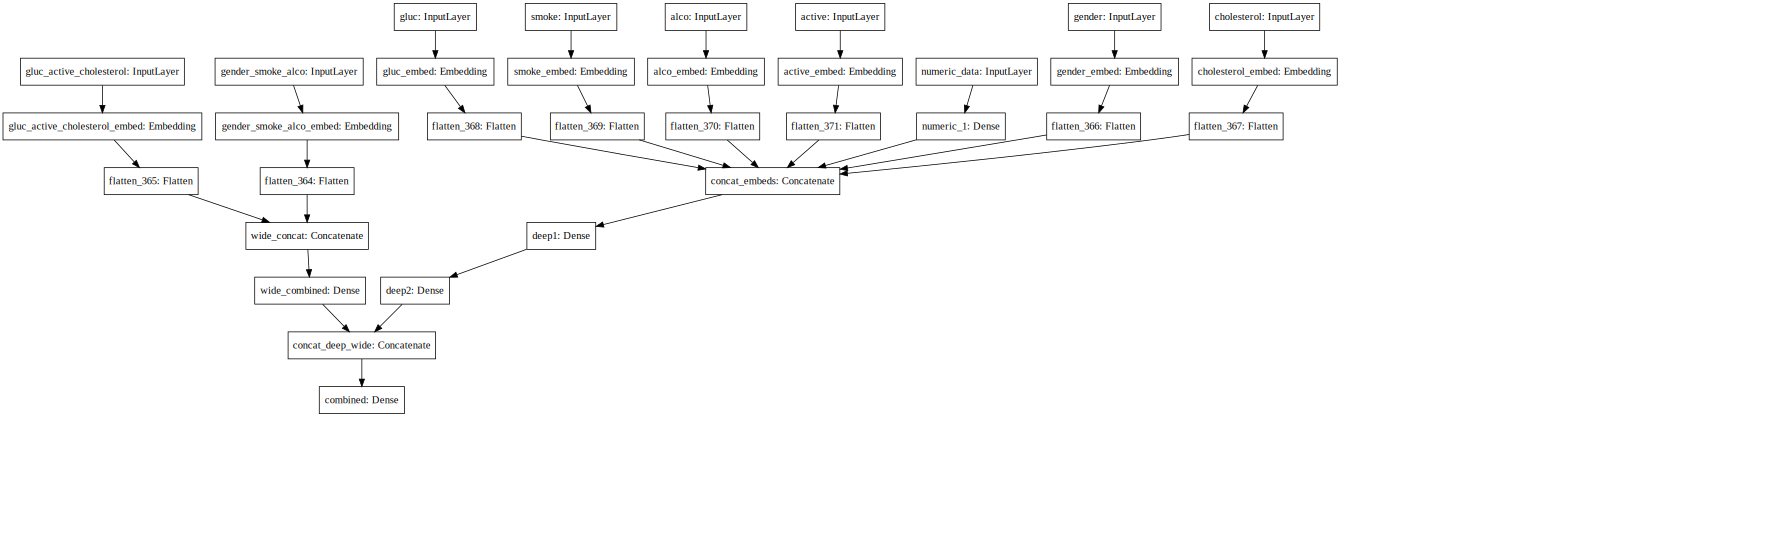

In [306]:
# you will need to install pydot properly on your machine to get this running
SVG(model_to_dot(model3).create(prog='dot', format='svg'))

In [307]:
%%time

model3.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=[metrics.Recall()])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history3 = model3.fit(X_ints_train3+ [X_train[numerical_headers].values],
                    y_train, 
                    epochs=20, 
                    batch_size=32, 
                    verbose=1, 
                    validation_split = 0.2)

/Users/zekaiwang/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 44800 samples, validate on 11200 samples
Epoch 1/20
44800/44800 [==============================] - 3s 59us/step - loss: 0.2031 - recall_26: 0.6656 - val_loss: 0.1886 - val_recall_26: 0.6889
Epoch 2/20
44800/44800 [==============================] - 2s 52us/step - loss: 0.1864 - recall_26: 0.6911 - val_loss: 0.1853 - val_recall_26: 0.6902
Epoch 3/20
44800/44800 [==============================] - 2s 52us/step - loss: 0.1845 - recall_26: 0.6907 - val_loss: 0.1848 - val_recall_26: 0.6841
Epoch 4/20
44800/44800 [==============================] - 2s 51us/step - loss: 0.1838 - recall_26: 0.6902 - val_loss: 0.1843 - val_recall_26: 0.6843
Epoch 5/20
44800/44800 [==============================] - 2s 51us/step - loss: 0.1834 - recall_26: 0.6916 - val_loss: 0.1837 - val_recall_26: 0.7018
Epoch 6/20
44800/44800 [==============================] - 2s 51us/step - loss: 0.1831 - recall_26: 0.6912 - val_loss: 0.1836 - val_recall_26: 0.7024
Epoch 7/20
44800/44800 [==============================] 

Text(0.5, 1.0, 'MSE Loss')

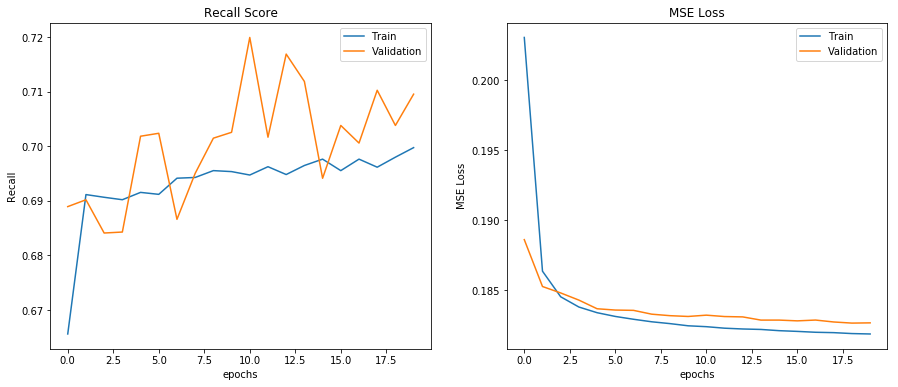

In [553]:
%matplotlib inline

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
p1, = plt.plot(history3.history['recall_26'])
p2, = plt.plot(history3.history['val_recall_26'])
plt.legend([p1, p2], ['Train', 'Validation'])
plt.ylabel('Recall')
plt.xlabel('epochs')
plt.title('Recall Score')

#plt.ylabel('Recall %')
#plt.title('Training')
#plt.subplot(2,2,2)
#plt.plot(history.history['val_recall_21'])
#plt.title('Validation')

plt.subplot(1,2,2)
p3, = plt.plot(history3.history['loss'])
p4, = plt.plot(history3.history['val_loss'])
plt.legend([p3, p4], ['Train', 'Validation'])
plt.ylabel('MSE Loss')
plt.xlabel('epochs')
plt.title('MSE Loss')

## Model 3-2

### The third combination with 5 hidden layers

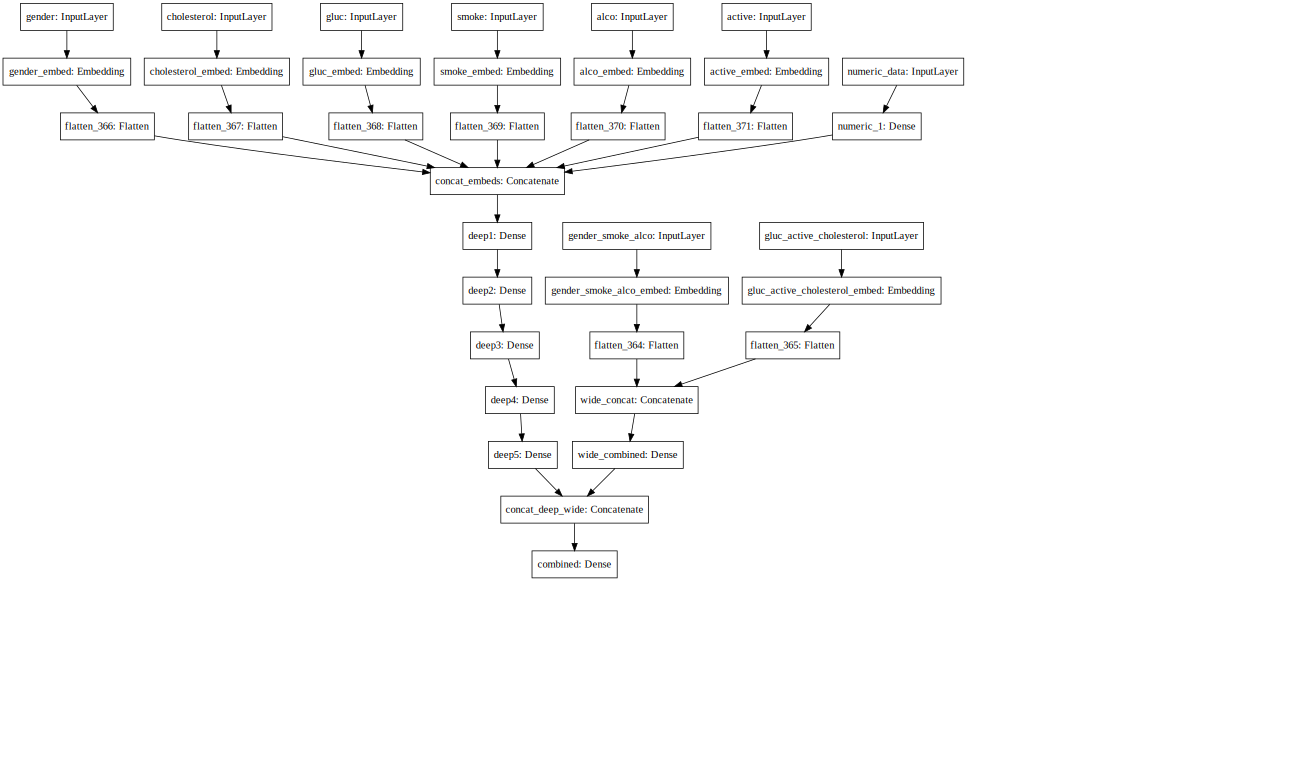

In [309]:
SVG(model_to_dot(model3_2).create(prog='dot', format='svg'))

In [310]:
%%time

model3_2.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=[metrics.Recall()])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history3_2 = model3_2.fit(X_ints_train3+ [X_train[numerical_headers].values],
                    y_train, 
                    epochs=20, 
                    batch_size=32, 
                    verbose=1, 
                    validation_split = 0.2)

/Users/zekaiwang/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 44800 samples, validate on 11200 samples
Epoch 1/20
44800/44800 [==============================] - 3s 65us/step - loss: 0.1852 - recall_27: 0.6954 - val_loss: 0.1829 - val_recall_27: 0.6769
Epoch 2/20
44800/44800 [==============================] - 3s 57us/step - loss: 0.1822 - recall_27: 0.6945 - val_loss: 0.1830 - val_recall_27: 0.6597
Epoch 3/20
44800/44800 [==============================] - 3s 57us/step - loss: 0.1818 - recall_27: 0.6925 - val_loss: 0.1821 - val_recall_27: 0.7056
Epoch 4/20
44800/44800 [==============================] - 3s 57us/step - loss: 0.1815 - recall_27: 0.6932 - val_loss: 0.1821 - val_recall_27: 0.6793
Epoch 5/20
44800/44800 [==============================] - 3s 59us/step - loss: 0.1813 - recall_27: 0.6926 - val_loss: 0.1819 - val_recall_27: 0.6875
Epoch 6/20
44800/44800 [==============================] - 3s 57us/step - loss: 0.1811 - recall_27: 0.6910 - val_loss: 0.1820 - val_recall_27: 0.7078
Epoch 7/20
44800/44800 [==============================] 

Text(0.5, 1.0, 'MSE Loss')

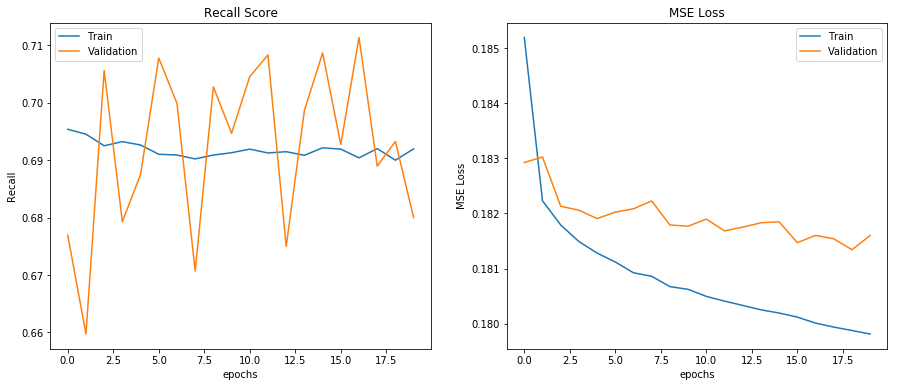

In [554]:
%matplotlib inline

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
p1, = plt.plot(history3_2.history['recall_27'])
p2, = plt.plot(history3_2.history['val_recall_27'])
plt.legend([p1, p2], ['Train', 'Validation'])
plt.ylabel('Recall')
plt.xlabel('epochs')
plt.title('Recall Score')

#plt.ylabel('Recall %')
#plt.title('Training')
#plt.subplot(2,2,2)
#plt.plot(history.history['val_recall_21'])
#plt.title('Validation')

plt.subplot(1,2,2)
p3, = plt.plot(history3_2.history['loss'])
p4, = plt.plot(history3_2.history['val_loss'])
plt.legend([p3, p4], ['Train', 'Validation'])
plt.ylabel('MSE Loss')
plt.xlabel('epochs')
plt.title('MSE Loss')

## Performance

Based on the bar plot, the first model has the best performance

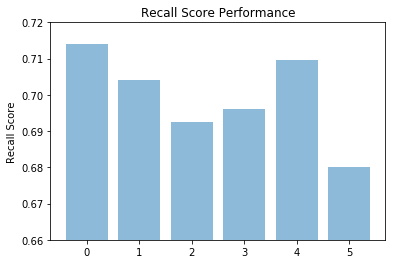

In [313]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(6)
Recall_score_performance = [history.history['val_recall_21'][19],
              history1_2.history['val_recall_22'][19],
              history2.history['val_recall_23'][19],
              history2_2.history['val_recall_25'][19],
              history3.history['val_recall_26'][19],
              history3_2.history['val_recall_27'][19]]

plt.bar(y_pos, Recall_score_performance,alpha=0.5)
#plt.xticks(x, objects)
plt.ylim(0.66,0.72)
plt.ylabel('Recall Score')
plt.title('Recall Score Performance')

plt.show()

## MLP 

Now I use keras to create a MLP model. In this part I used train and test data set and ROC plot to compare these two models.

In [336]:
# combine the features into a single large matrix

# Build a computation graph
# This returns a tensor
# Initial variable for keras and the shape is number of features in dataset (1-D tensor)
# That means each instance in dataset will be 1-D tensor
inputs = Input(shape=(X_train.shape[1],))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(units=30, activation='relu')(inputs)# 10 neuron
x = Dense(units=10, activation='relu')(x)
predictions = Dense(1,activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model_MLP = Model(inputs=inputs, outputs=predictions)

In [337]:
model_MLP.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=[metrics.Recall()])

model_MLP.summary()

Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 11)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 30)                360       
_________________________________________________________________
dense_35 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 11        
Total params: 681
Trainable params: 681
Non-trainable params: 0
_________________________________________________________________


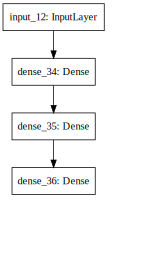

In [338]:
SVG(model_to_dot(model_MLP).create(prog='dot', format='svg'))

In [339]:
%%time

history_MLP = model_MLP.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1,validation_split = 0.2)


# the model will remember what the model.fit() state,
# when it runs the model, it actually run another 10 epoch, get started from where they were before

Train on 44800 samples, validate on 11200 samples
Epoch 1/20
44800/44800 [==============================] - 1s 29us/step - loss: 0.1997 - recall_29: 0.6632 - val_loss: 0.1910 - val_recall_29: 0.6829
Epoch 2/20
44800/44800 [==============================] - 1s 26us/step - loss: 0.1887 - recall_29: 0.6821 - val_loss: 0.1889 - val_recall_29: 0.6639
Epoch 3/20
44800/44800 [==============================] - 1s 26us/step - loss: 0.1871 - recall_29: 0.6851 - val_loss: 0.1877 - val_recall_29: 0.6904
Epoch 4/20
44800/44800 [==============================] - 1s 26us/step - loss: 0.1866 - recall_29: 0.6885 - val_loss: 0.1875 - val_recall_29: 0.6934
Epoch 5/20
44800/44800 [==============================] - 1s 26us/step - loss: 0.1861 - recall_29: 0.6890 - val_loss: 0.1873 - val_recall_29: 0.6961
Epoch 6/20
44800/44800 [==============================] - 1s 26us/step - loss: 0.1859 - recall_29: 0.6905 - val_loss: 0.1872 - val_recall_29: 0.6852
Epoch 7/20
44800/44800 [==============================] 

In [341]:
pd.DataFrame(history_MLP.history).head(10)

,val_loss,val_recall_29,loss,recall_29
0,0.191022,0.682853,0.199685,0.663231
1,0.188907,0.663860,0.188733,0.682052
2,0.187749,0.690378,0.187122,0.685055
3,0.187527,0.693424,0.186550,0.688461
4,0.187259,0.696112,0.186147,0.689043
5,0.187228,0.685182,0.185930,0.690477
6,0.186929,0.704533,0.185688,0.691777
7,0.186881,0.705608,0.185513,0.693793
8,0.186768,0.689482,0.185357,0.694421
9,0.186676,0.695753,0.185192,0.695631


Text(0.5, 1.0, 'MSE Loss')

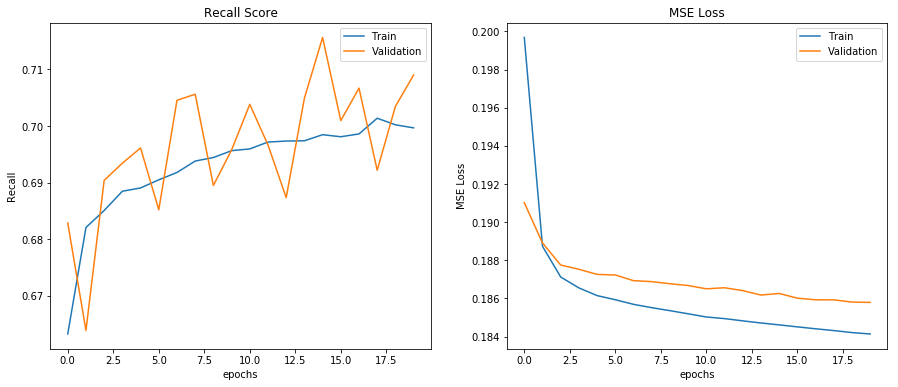

In [555]:
%matplotlib inline

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
p1, = plt.plot(history_MLP.history['recall_29'])
p2, = plt.plot(history_MLP.history['val_recall_29'])
plt.legend([p1, p2], ['Train', 'Validation'])
plt.ylabel('Recall')
plt.xlabel('epochs')
plt.title('Recall Score')

#plt.ylabel('Recall %')
#plt.title('Training')
#plt.subplot(2,2,2)
#plt.plot(history.history['val_recall_21'])
#plt.title('Validation')

plt.subplot(1,2,2)
p3, = plt.plot(history_MLP.history['loss'])
p4, = plt.plot(history_MLP.history['val_loss'])
plt.legend([p3, p4], ['Train', 'Validation'])
plt.ylabel('MSE Loss')
plt.xlabel('epochs')
plt.title('MSE Loss')


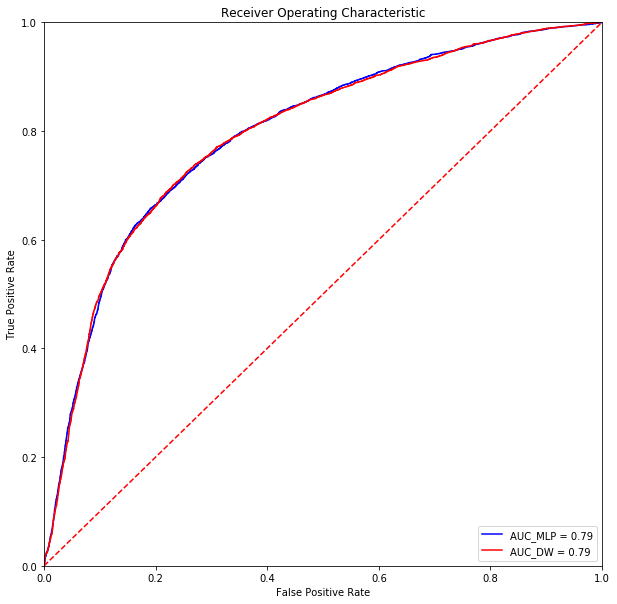

In [369]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
yhat_proba = model_MLP.predict(X_test)

yhat_proba1 = model.predict(X_ints_test + [X_test[numerical_headers].values])

# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, yhat_proba)
roc_auc = sklearn.metrics.auc(fpr, tpr)

fpr1, tpr1, threshold1 = sklearn.metrics.roc_curve(y_test, yhat_proba1)
roc_auc1 = sklearn.metrics.auc(fpr, tpr)

plt.figure(figsize=(10,10))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC_MLP = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, 'r', label = 'AUC_DW = %0.2f' % roc_auc1)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Based on ROC plot, MLP and deep wide network almost have the same performance. Both of them have the same AUC value and the trend of these two plots is also almost same. Therefore, there is strong evidence to believe these two of models have the same performance.

## Exceptional Work

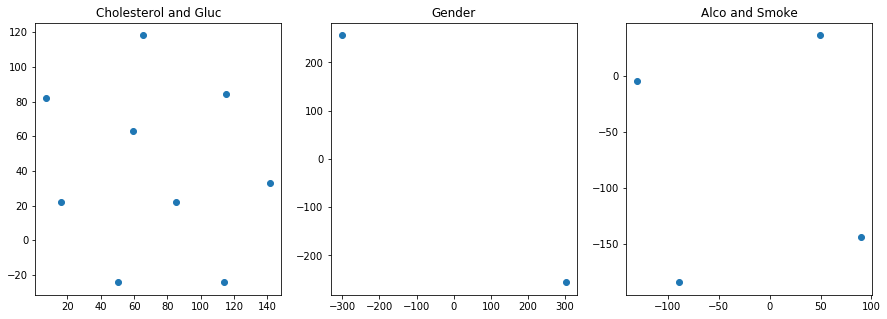

In [538]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris,load_digits
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

embedding_weights1 = model.get_layer('cholesterol_gluc_embed').get_weights()[0]
X_tsne1 = TSNE(n_components=2,random_state=33).fit_transform(embedding_weights1)

embedding_weights2 = model.get_layer('gender_embed').get_weights()[0]
X_tsne2 = TSNE(n_components=2,random_state=33).fit_transform(embedding_weights2)

embedding_weights3 = model.get_layer('alco_smoke_embed').get_weights()[0]
X_tsne3 = TSNE(n_components=2,random_state=33).fit_transform(embedding_weights3)

plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.title('Cholesterol and Gluc')
plt.scatter(X_tsne1[:, 0], X_tsne1[:, 1])

plt.subplot(1,3,2)
plt.title('Gender')
plt.scatter(X_tsne2[:, 0], X_tsne2[:, 1])

plt.subplot(1,3,3)
plt.title('Alco and Smoke')
plt.scatter(X_tsne3[:, 0], X_tsne3[:, 1])


plt.show()


In this part, I checked the 'cholesterol_gluc_embed', 'gender_embed', and 'alco_smoke_embed' from the  first model, which has the best performance during 6 models. Based on the scatter plot, it is obvious that gender has very large difference and the combination of alcohol and some and the combination of cholesterol and gluc also has large differnece between each different level combination. Therefore, the embedding can represent the difference between each categorical features' level